In [3]:
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
import math
import numpy as np
############ LOG SCALING - 
###PREDICTION TASK - with cross-promotion
###Cross-validation
train = pd.read_csv('jan_may_2017_links_cross_posting_info.csv')
##drop dups
# train = train.sort_values('ext_table1_firsthour_stats_date', ascending = False).drop_duplicates(subset=['buzz_post_buzz_id', 'ext_external_id'], keep = 'last')
all_pages = list(train.buzz_account_display_name.unique())

####RESTRICT PAGE-WISE
# train = train[train['buzz_account_display_name'] == 'BuzzFeed']

print("WITH cross-promotion features")

features = [
       'ext_table1_consumptions_by_type__link_clicks',
       'ext_table1_consumptions_by_type__other_clicks',
       'ext_table1_reactions_like_total',
       'ext_table1_stories_by_action_type__comment',
       'ext_table1_stories_by_action_type__like',
       'ext_table1_stories_by_action_type__share', 'ext_table1_engaged_fan',
       'ext_table1_fan_reach', 'ext_table1_impressions',
       'ext_table1_impressions_fan',
        ]

    
alt_inf = len(all_pages) + 1
train = train.replace(math.inf, alt_inf)

# ####add the category variable for each of the pages in col_pages
for pg in all_pages:
    features.append(pg)

###generate DFs for analysis - X and Y
df = train[features]


train['clicks_bucket'] = (np.log(train['ext_twodays_consumptions_by_type__link_clicks']+1)).astype(int)
train['share_bucket'] = (np.log(train['ext_twodays_stories_by_action_type__share']+1)).astype(int)

WITH cross-promotion features


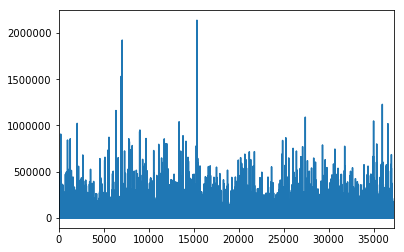

In [14]:
train['ext_twodays_consumptions_by_type__link_clicks'].plot()

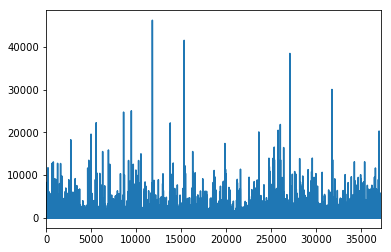

In [13]:
train['ext_twodays_stories_by_action_type__share'].plot()

In [23]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=5, random_state=None, shuffle=False)


In [52]:
###log buckets only
#####CLASSIFICATION
import pandas as pd
from pandas.stats.api import ols
from sklearn import datasets, linear_model
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
import math
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

train = pd.read_csv('jan_may_2017_links_cross_posting_info.csv')
all_pages = list(train.buzz_account_display_name.unique())

# subsample = 1
subsample = 0

if subsample == 1:
    train = train[:1000]

print("WITH cross-promotion features")

features = [
       'ext_table1_consumptions_by_type__link_clicks',
       'ext_table1_consumptions_by_type__other_clicks',
       'ext_table1_reactions_like_total',
       'ext_table1_stories_by_action_type__comment',
       'ext_table1_stories_by_action_type__like',
       'ext_table1_stories_by_action_type__share', 'ext_table1_engaged_fan',
       'ext_table1_fan_reach', 'ext_table1_impressions',
       'ext_table1_impressions_fan',
        ]

###convert to log-scale
for feat in features:
    train[feat] = np.log(train[feat]+1)

alt_inf = len(all_pages) + 1
train = train.replace(math.inf, alt_inf)

# ####add the category variable for each of the pages in col_pages
for pg in all_pages:
    features.append(pg)


###let's take log_100 instead of 10?

train['clicks_bucket'] = (np.log(train['ext_twodays_consumptions_by_type__link_clicks']+1)).astype(int)
train['share_bucket'] = (np.log(train['ext_twodays_stories_by_action_type__share']+1)).astype(int)

y_clicks = train['clicks_bucket']
y_share = train['share_bucket']

metric = 'share'

from sklearn.model_selection import KFold

fold = 0
cv_folds = 5
kf = KFold(n_splits = cv_folds)

X = train[features]

for train_index, test_index in kf.split(X):
    print("Fold ", fold)
    fold += 1
    
    # metric = 'clicks'

    if metric == 'share':
        y = y_share
        print("Testing for shares!")
    else:
        y = y_clicks
        print("Testing for clicks!")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    cv = 2
    nb_alpha = 0.01
    # classifier = 'svm'
    classifier = 'nb'
    # classifier = 'logit'
    # classifier ='rf'
    logit_c = 1e5

    ####classifier
    # clf = LinearSVC(C=1)
    if classifier == 'nb':
        clf = MultinomialNB(alpha = nb_alpha)
    if classifier == 'logit':
        clf = linear_model.LogisticRegression(C=logit_c)
    #   Try penalty='l2' and 'l1'
    if classifier == 'rf':
        clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    else:
        clf = svm.SVC(kernel='linear')
        ###try different kernels

    clf = clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
#     print("Performance on ", metric, " : ", precision_recall_fscore_support(y_test, predicted, average='macro'))  
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, average='macro')
    accuracy = accuracy_score(y_test, predicted)
    print("Accuracy: %f, Precision: %f, Recall: %f, F-score: %f", accuracy, precision, recall, fscore)
    # predicted = cross_val_predict(clf, X, y, cv=cv)
# scores = metrics.accuracy_score(y, predicted)
# # scores = cross_val_score(clf, X, y, cv = 10)
# # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# print("Accuracy: ", scores)

    # metric = 'share'
    metric = 'clicks'

    if metric == 'share':
        y = y_share
        print("Testing for shares!")
    else:
        y = y_clicks
        print("Testing for clicks!")

    ####classifier
    # clf = LinearSVC(C=1)
    if classifier == 'nb':
        clf = MultinomialNB(alpha = nb_alpha)
    if classifier == 'logit':
        clf = linear_model.LogisticRegression(C=logit_c)
    #   Try penalty='l2' and 'l1'
    if classifier == 'rf':
        clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    else:
        clf = svm.SVC(kernel='linear')
        ###try different kernels
    clf = clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, average='macro')
    accuracy = accuracy_score(y_test, predicted)
    print("Accuracy: %f, Precision: %f, Recall: %f, F-score: %f", accuracy, precision, recall, fscore)
   
# predicted = cross_val_predict(clf, X, y, cv=cv)
# scores = metrics.accuracy_score(y, predicted)
# # scores = cross_val_score(clf, X, y, cv = 10)
# # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# print("Accuracy: ", scores)

WITH cross-promotion features
Fold  0
Testing for shares!


/Users/eshwarchandrasekharan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: %f, Precision: %f, Recall: %f, F-score: %f 0.624949644152 0.565267626969 0.541609905926 0.550051575409
Testing for clicks!
Accuracy: %f, Precision: %f, Recall: %f, F-score: %f 0.624949644152 0.565267626969 0.541609905926 0.550051575409
Fold  1
Testing for clicks!
Accuracy: %f, Precision: %f, Recall: %f, F-score: %f 0.688960515713 0.633545886337 0.626838400234 0.6240569113
Testing for clicks!
Accuracy: %f, Precision: %f, Recall: %f, F-score: %f 0.688960515713 0.633545886337 0.626838400234 0.6240569113
Fold  2
Testing for clicks!
Accuracy: %f, Precision: %f, Recall: %f, F-score: %f 0.702793446146 0.612560742038 0.584390777365 0.588294992111
Testing for clicks!
Accuracy: %f, Precision: %f, Recall: %f, F-score: %f 0.702793446146 0.612560742038 0.584390777365 0.588294992111
Fold  3
Testing for clicks!
Accuracy: %f, Precision: %f, Recall: %f, F-score: %f 0.676201987644 0.560536208193 0.602838566035 0.573359296413
Testing for clicks!
Accuracy: %f, Precision: %f, Recall: %f, F-score: